In [2]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
plt.show() # plot sometimes dont show up otherwise
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from osgeo import gdal
import datetime as datetime
import numpy as np
import glob as glob


In [3]:
# The main function which reads the different logs and extract relevant informations.
# The correlation, triangulation, and blend logs are scanned.
# Adapted for treatment of pair of images, not triplet at the moment.

def get_ASP_log_info(logFolder):
    ASPstep = "log-stereo_corr"
    tile_ASP_info = {}
    time_exec_unique=[]
    rec=[]
    tile_folder_list=glob.glob(logFolder+"/*/")
    for tile_folder in tile_folder_list:
        if "pair" not in tile_folder:
            #print(tile_folder)
            inLoglist=glob.glob(tile_folder+"/*"+ASPstep+"*.txt")
            if len(inLoglist)>0:
                    inLog=inLoglist[0]
                    tile_id = inLog.split('/')[-1].split("-")[0]
                    tile_ASP_info[tile_id] = {}

                    x0=int(inLog.split('/')[-1].split('_')[0])
                    y0=int(inLog.split('/')[-1].split('_')[1])
                    lx=int(inLog.split('/')[-1].split('_')[2])
                    ly=int(inLog.split('/')[-1].split('_')[3].split('-')[0])
                    tile_ASP_info[tile_id].update( {"x":x0, "y":y0, "lx":lx, "ly":ly,} )

    for tile_folder in tile_folder_list:
        if "pair" not in tile_folder:
            #print(tile_folder)
            for file_name, var_name in (("log-stereo_corr","corr"),
                                       ("log-stereo_tri","tri"),
                                       ("log-stereo_blend","blend")):
                # Correlation step
                inLoglist = glob.glob(tile_folder+"/*"+file_name+"*.txt")
                if len(inLoglist)>0:
                        inLog = inLoglist[0]
                        tile_id = inLog.split('/')[-1].split("-")[0]
                        tile_ASP_info[tile_id].update({var_name+"_warning":False, var_name+"_error":False, var_name+"_warning_list":[], var_name+"_error_list":[]})
                        with open(inLog) as log:
                            for line in log:
                                #print(line)
                                if 'started' in line:
                                    dstart = datetime.datetime.strptime(line[-21:-2],"%Y-%m-%d %H:%M:%S")

                                elif 'FINISHED' in line:
                                    dend = datetime.datetime.strptime(line[2:22],"%Y-%b-%d %H:%M:%S")

                                elif ('Warning' in line) | ('warning' in line) | ('WARNING' in line):
                                    tile_ASP_info[tile_id][var_name+"_warning"] = True
                                    tile_ASP_info[tile_id][var_name+"_warning_list"].append( line)

                                elif ('Error' in line) | ('error' in line) | ('ERROR' in line):
                                    if "compute-error-vector" not in line:
                                        tile_ASP_info[tile_id][var_name+"_error"] = True
                                        tile_ASP_info[tile_id][var_name+"_error_list"].append(line)

                                elif ("Rejected" in line) and ( "vertices" in line):
                                    tile_ASP_info[tile_id]["tri_vertices_total"] = int(line.split("Rejected ")[1].split("/")[1].split(" ")[0])
                                    tile_ASP_info[tile_id]["tri_vertices_rejected"] = int(line.split("Rejected ")[1].split("/")[0])
                                    tile_ASP_info[tile_id]["tri_vertices_rejected_pct"] =  int(line.split("Rejected ")[1].split("(")[1].split("%")[0])
                                elif "Search range" in line:
                                    tile_ASP_info[tile_id]["corr_search_range_origin_x"] = int( line.split("Origin: (")[1].split(", ")[0] )
                                    tile_ASP_info[tile_id]["corr_search_range_origin_origin_y"] = int( line.split("Origin: (")[1].split(", ")[1].split(")")[0].replace(")","") )
                                    corr_search_range_origin_width= int( line.split("width: ")[1].split(" ")[0] )
                                    tile_ASP_info[tile_id]["corr_search_range_origin_height"] = int( line.split("height: ")[1].split(" ")[0].replace(")","") )
                        dexec = dend - dstart   

                        tile_ASP_info[tile_id][var_name+"_exec_time_start"] = dstart
                        tile_ASP_info[tile_id][var_name+"_exec_time_end"] = dend
                        tile_ASP_info[tile_id][var_name+"_exec_time_duration"] = dexec

            #print(tile_folder)
            for file_name, var_name in (("corr-resource","corr"),
                                       ("tri-resource","tri"),
                                       ("blend-resource","blend")):        
                # Correlation step
                inLoglist = glob.glob(tile_folder+"/*"+file_name+"*.txt")
                if len(inLoglist)>0:
                        inLog = inLoglist[0]
                        tile_id = inLog.split('/')[-1].split("-")[0]
                        with open(inLog) as log:
                            for line in log:
                                if "=" in line:
                                    time_exec = float(line.split("=")[1].split(" ")[0].split(":")[1])
                                    memory = int(line.split("=")[2].split(" ")[0])
                                    unit = line.split("=")[2].split(" ")[1].split("(")[1].split(")")[0]
                                    if unit == "kb":
                                        memory_mb = memory/1000.
                                    elif unit == "mb":
                                        memory_mb = memory

                        tile_ASP_info[tile_id][var_name+"_exec_time_memory_mb"] = memory_mb
                        tile_ASP_info[tile_id][var_name+"_exec_time_elapsed"] = time_exec # this matches the *time_duration calculated before
    return tile_ASP_info

In [4]:
# Enter the path of the folder where ASP output are produced
logFolder = "/home/ad/deschampsc/work/proj/Pleiades_Snow_World/product/run_COP30/GrandesRousses/20190513/dem_final"
tile_ASP_info = get_ASP_log_info( logFolder)

In [10]:
# Print all the error and warning messages found
for var_name in ["corr_warning", "corr_error", "tri_warning", "tri_error", "blend_warning", "blend_error"]:
    for tile_name in tile_ASP_info:
        if tile_ASP_info[tile_name][var_name]:
            print( tile_ASP_info[tile_name][var_name+"_list"] + ["in " + var_name + " log"] + ["tile " + tile_name] )


['2024-03-06 17:26:03 {0} [ fileio ] : Error: GdalIO: ./201905131033136_GSD2-6144_32768_2048_2048/6144_32768_2048_2048-Dnosym.tif: No such file or directory (code = 4)\n', 'in blend_error log', 'tile 8192_32768_2048_2048']
['2024-03-06 17:26:02 {0} [ fileio ] : Error: GdalIO: ./201905131033136_GSD2-6144_32768_2048_2048/6144_32768_2048_2048-Dnosym.tif: No such file or directory (code = 4)\n', 'in blend_error log', 'tile 6144_32768_2048_2048']
['2024-03-06 17:26:27 {0} [ fileio ] : Error: GdalIO: ./201905131033136_GSD2-12288_34816_2048_2048/12288_34816_2048_2048-Dnosym.tif: No such file or directory (code = 4)\n', 'in blend_error log', 'tile 10240_36864_2048_465']
['2024-03-06 17:25:35 {0} [ fileio ] : Error: GdalIO: ./201905131033136_GSD2-6144_32768_2048_2048/6144_32768_2048_2048-Dnosym.tif: No such file or directory (code = 4)\n', 'in blend_error log', 'tile 4096_30720_2048_2048']
['2024-03-06 17:26:21 {0} [ fileio ] : Error: GdalIO: ./201905131033136_GSD2-18432_36864_2048_465/18432_36

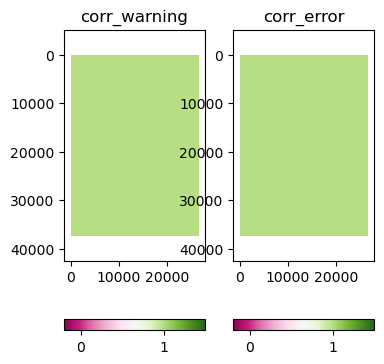

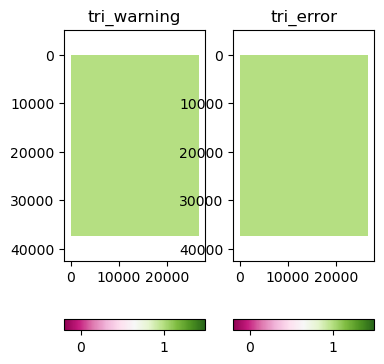

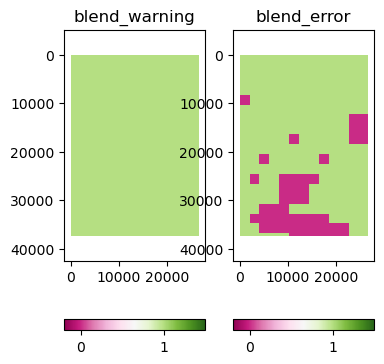

In [17]:
# Map the tiles which gave warning or error messages
for step_name in ["corr", "tri", "blend"]: #["corr_warning", "corr_error", "tri_warning", "tri_error", "blend_warning", "blend_error"]:
    fig, axs = plt.subplots(1, 2, figsize=(4,3))
    for i, message_type in enumerate(["_warning", "_error"]):
        var_name = step_name + message_type
        tile_data, tile_geom = [], [] 
        for tile_name in tile_ASP_info:
            tile_geom.append(mpl.patches.Rectangle((tile_ASP_info[tile_name]["x"],tile_ASP_info[tile_name]["y"]),
                                                   width=tile_ASP_info[tile_name]["lx"],height=tile_ASP_info[tile_name]["ly"],ec='k'))                      
            tile_data.append(int(not tile_ASP_info[tile_name][var_name]))
            
        ## plot the map of the execution time per tile
        colec=PatchCollection(tile_geom, edgecolor='k', lw=0, cmap=mpl.cm.PiYG, zorder=100, clim=(-0.2,1.5))
        colec.set_array(np.array(tile_data))
        axs[i].add_collection(colec)  

        axins = inset_axes(axs[i],width="100%",height="5%",loc='lower center',borderpad=-5)
        fig.colorbar(colec, cax=axins, orientation="horizontal")

        axs[i].axis('equal')
        axs[i].set_title(var_name)
        axs[i].invert_yaxis()
        

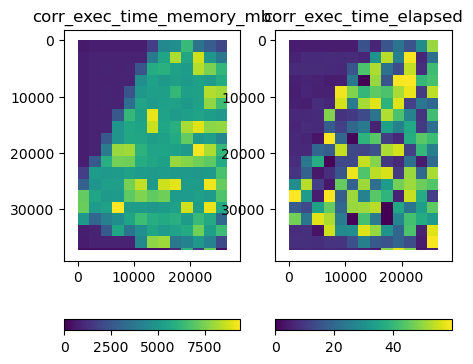

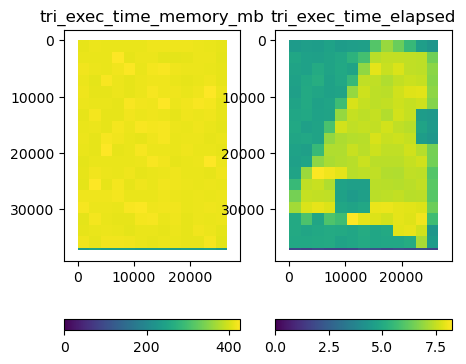

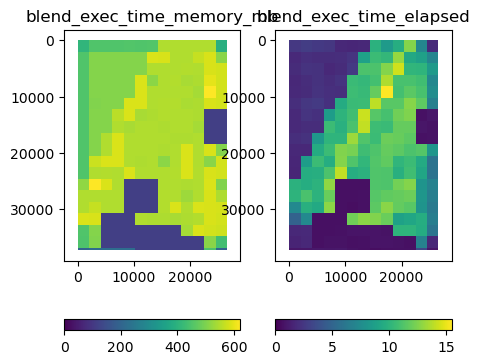

In [20]:
# Map the tiles which gave warning or error messages
for step_name in ["corr", "tri", "blend"]: #["corr_warning", "corr_error", "tri_warning", "tri_error", "blend_warning", "blend_error"]:
    fig, axs = plt.subplots(1, 2, figsize=(5,3))
    for i, var_type in enumerate(["_exec_time_memory_mb", "_exec_time_elapsed"]):
        var_name = step_name + var_type
#        for var_name in ["corr_exec_time_memory_mb", "tri_exec_time_memory_mb", "blend_exec_time_memory_mb", "corr_exec_time_elapsed", "tri_exec_time_elapsed", "blend_exec_time_elapsed", "tri_vertices_rejected_pct", "tri_vertices_total" ]: #"corr_search_range_origin_width", "corr_search_range_origin_height"]:
        tile_data, tile_geom = [], [] 
        for tile_name in tile_ASP_info:
            tile_geom.append(mpl.patches.Rectangle((tile_ASP_info[tile_name]["x"],tile_ASP_info[tile_name]["y"]),
                                                   width=tile_ASP_info[tile_name]["lx"],height=tile_ASP_info[tile_name]["ly"],ec='k'))                      
            tile_data.append(tile_ASP_info[tile_name][var_name])
        ## plot the map of the execution time per tile
        colec=PatchCollection(tile_geom,edgecolor='k', lw=0, cmap=mpl.cm.viridis, zorder=100, clim=(0,np.max(tile_data)))
        colec.set_array(np.array(tile_data))
        axs[i].add_collection(colec)  

        axins = inset_axes(axs[i],width="100%",height="5%",loc='lower center',borderpad=-5)
        fig.colorbar(colec, cax=axins, orientation="horizontal")

        axs[i].axis('equal')
        axs[i].set_title(var_name)
        axs[i].invert_yaxis()
        

In [21]:
# Temporal plot of memomery used
t_init, t_end = [], []
for tile_name in tile_ASP_info:
    t_init.append(tile_ASP_info[tile_name]["corr_exec_time_start"])
    t_end.append(tile_ASP_info[tile_name]["tri_exec_time_end"])
tmin = min(t_init)
tmax = max(t_end)

trun = tmax-tmin
mem_arr_corr  = np.zeros((len(tile_ASP_info), trun.seconds))
mem_arr_tri   = np.zeros((len(tile_ASP_info), trun.seconds))
mem_arr_blend = np.zeros((len(tile_ASP_info), trun.seconds))

for itile, tile_name in enumerate(tile_ASP_info):
    t0 = (tile_ASP_info[tile_name]["corr_exec_time_start"]-tmin).seconds
    t1 = (tile_ASP_info[tile_name]["corr_exec_time_end"]  -tmin).seconds
    mem_arr_corr[itile, t0:t1] = tile_ASP_info[tile_name]["corr_exec_time_memory_mb"]
    
    t0 = (tile_ASP_info[tile_name]["tri_exec_time_start"]-tmin).seconds
    t1 = (tile_ASP_info[tile_name]["tri_exec_time_end"]  -tmin).seconds
    mem_arr_tri[itile, t0:t1] = tile_ASP_info[tile_name]["tri_exec_time_memory_mb"]
    
    t0 = (tile_ASP_info[tile_name]["blend_exec_time_start"]-tmin).seconds
    t1 = (tile_ASP_info[tile_name]["blend_exec_time_end"]  -tmin).seconds
    mem_arr_blend[itile, t0:t1] = tile_ASP_info[tile_name]["blend_exec_time_memory_mb"]


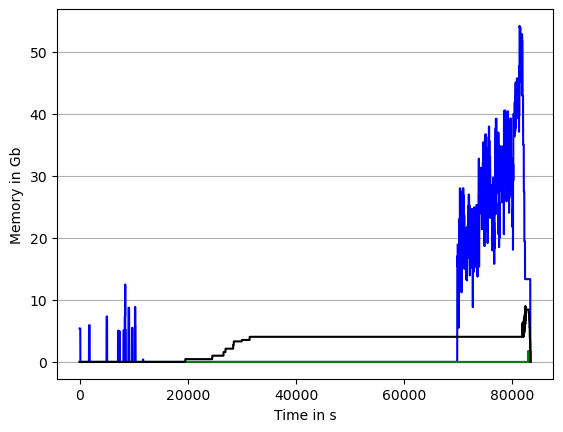

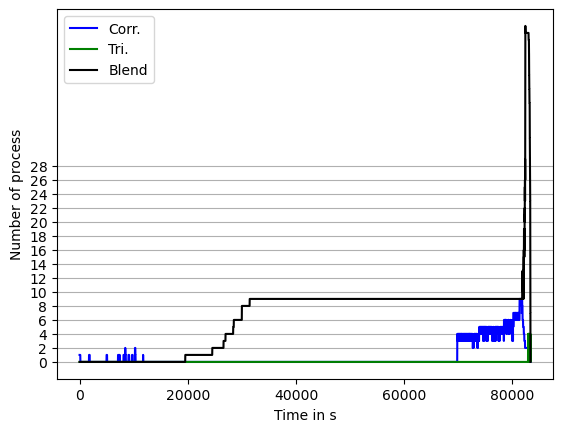

In [22]:
# Time series of memory consumption
plt.figure()
plt.plot(np.sum(mem_arr_corr, axis=0)/1000,"b")
plt.plot(np.sum(mem_arr_tri, axis=0)/1000,"g")
plt.plot(np.sum(mem_arr_blend, axis=0)/1000,"k")
plt.grid(axis="y")
plt.xlabel("Time in s")
plt.ylabel("Memory in Gb")

# Time series of number of processes running (fail when memory gets near 0)
plt.figure()
plt.plot(np.sum((mem_arr_corr>0), axis=0),"b", label="Corr.")
plt.plot(np.sum((mem_arr_tri>0), axis=0),"g", label="Tri.")
plt.plot(np.sum((mem_arr_blend>0), axis=0),"k", label="Blend")
plt.yticks(np.arange(0,30,2))
plt.grid(axis="y")
plt.xlabel("Time in s")
plt.ylabel("Number of process")
plt.legend()